### Notebook to genereate boxplots for ddt(CWV) binned by cloud classification scheme.

Assumes output is in a single netcdf file on pressure levels.

James Ruppert  
jruppert@ou.edu  
12/15/23

In [1]:
import numpy as np
import matplotlib
from matplotlib import ticker
import matplotlib.pyplot as plt
import sys
from thermo_functions import theta_virtual, relh, theta_equiv
from precip_class import precip_class
import seaborn as sns
import xarray as xr
from memory_usage import memory_usage
from read_functions import *

#### Main settings

In [2]:
# Number of sample time steps
nt=200 # will be chopped down to max available
# nt=48

#### Additional settings and directories

In [3]:
storm = 'haiyan'
# storm = 'maria'

# main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/wrfenkf/"
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"
figdir = "/home/jamesrup/figures/tc/ens/"+storm+'/'
datdir2 = 'post/d02/'

# Tests to read and compare
# tests = ['crfon','ncrf']
# if storm == 'haiyan':
#     tests = ['ctl','ncrf36h']
# elif storm == 'maria':
#     # tests = ['ctl','ncrf36h']
#     tests = ['ctl','ncrf48h']
tests = ['ctl']

time_neglect=12 # time steps from start to neglect

# Members
nmem = 10 # number of ensemble members (1-5 have NCRF)
nmem = 2
enstag = str(nmem)

In [4]:
# Ensemble member info
memb0=1 # Starting member to read
memb_nums=np.arange(memb0,nmem+memb0,1)
memb_nums_str=memb_nums.astype(str)
nustr = np.char.zfill(memb_nums_str, 2)
memb_all=np.char.add('memb_',nustr)

# Get dimensions
datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'+datdir2
nt_data, nz, nx1, nx2, pres = get_file_dims(datdir)
dp = (pres[1]-pres[0])*1e2 # Pa
nt=np.min([nt,nt_data-time_neglect])

# Get WRF file list
# datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'
# wrffiles, lat, lon = get_wrf_filelist(datdir)

#### NetCDF variable read functions

In [5]:
memory_usage()

Total:      134.320787456 GB
Avail:      128.721809408 GB
Used:       2.275028992 GB
Free:       127.60312627200001 GB
Active:     0.592883712 GB
Inactive:   4.303196160000001 GB


#### Main loops and compositing

In [6]:
# Main read loops for 3D (dependent) variables

# Arrays to save variables
ntest=len(tests)
dims = (ntest, nmem, nt, nx1, nx2)
strat_all  = np.ma.zeros(dims)
cwv_1hr    = np.ma.zeros(dims)

for ktest in range(ntest):

    test_str=tests[ktest]

    # This has been tested for corresponding time steps:
    #   t0=37,1 are the first divergent time steps in CTL,NCRF
    #   t0=25,1 are the first divergent time steps in NCRF,CRFON
    # if test_str == 'ctl':
    #     if tests[1] == 'ncrf36h':
    #         t0=36
    #     elif tests[1] == 'ncrf48h':
    #         t0=48
    # elif test_str == 'ncrf36h':
    #     t0=t0_test
    # elif test_str == 'ncrf48h':
    #     t0=t0_test
    # elif test_str == 'crfon':
    #     t0=0
    t0=time_neglect # neglect the first 12 time steps
    t1=t0+nt

    # t0+=1 # add one time step since NCRF(t=0) = CTL
    # t1 = t0+nt

    print('Running test: ',test_str)

    # Loop over ensemble members

    for imemb in range(nmem):
    
        print('Running imemb: ',memb_all[imemb])
    
        datdir = main+storm+'/'+memb_all[imemb]+'/'+test_str+'/'+datdir2
        datdir3d = datdir #+'v2/'
        print(datdir)

        # Stratiform ID
        q_int = read_qcloud(datdir,t0,t1) # mm
        strat = precip_class(q_int)

        # CWV
        varname='PW'
        cwv = var_read_2d(datdir3d,varname,t0,t1) # mm
        # ddtq = np.gradient(lwnet, axis=0) # mm/hr

        # Save variables for each ens member
        strat_all[ktest,imemb,:,:,:] = strat
        cwv_1hr[ktest,imemb,:,:,:]   = cwv


Running test:  ctl
Running imemb:  memb_01
/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_01/ctl/post/d02/


Running imemb:  memb_02
/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_02/ctl/post/d02/


In [7]:
memory_usage()

Total:      134.320787456 GB
Avail:      123.154640896 GB
Used:       7.842230272 GB
Free:       122.03616256000001 GB
Active:     6.139244544 GB
Inactive:   4.303552512 GB


### Compute DDTQ over different time scales

In [17]:
# Smoothing function
def time_smooth_var(var, nwindow):
    data_xr = xr.DataArray(var,
                            coords={'test':np.arange(ntest), 'memb':memb_nums, 'time':np.arange(nt),
                            'y':np.arange(nx1), 'x':np.arange(nx2)},
                            dims=['test','memb','time','y','x'])
    data_smooth = data_xr.rolling(time=nwindow, center=True).mean()
    return data_smooth.to_masked_array()

In [18]:
axis=2

ddtq_1hr = np.gradient(cwv_1hr, axis=axis)

# CWV with rolling average
nwindow=3
cwv_3hr = time_smooth_var(cwv_1hr, nwindow)
ddtq_3hr = np.gradient(cwv_3hr, axis=axis)

nwindow=5
cwv_5hr = time_smooth_var(cwv_1hr, nwindow)
ddtq_5hr = np.gradient(cwv_5hr, axis=axis)

nwindow=7
cwv_7hr = time_smooth_var(cwv_1hr, nwindow)
ddtq_7hr = np.gradient(cwv_7hr, axis=axis)

nwindow=9
cwv_9hr = time_smooth_var(cwv_1hr, nwindow)
ddtq_9hr = np.gradient(cwv_9hr, axis=axis)

In [19]:
memory_usage()

Total:      134.320787456 GB
Avail:      110.92266188800001 GB
Used:       20.075270144 GB
Free:       109.814542336 GB
Active:     21.978054656 GB
Inactive:   0.671879168 GB


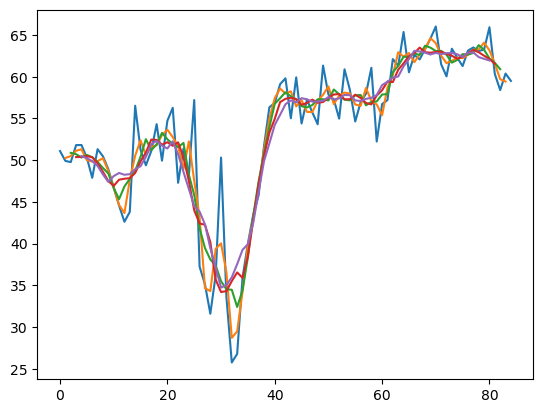

In [20]:
# Example time series of smoothed cwv

plt.plot(cwv_1hr[0,1,:,400,300])
plt.plot(cwv_3hr[0,1,:,400,300])
plt.plot(cwv_5hr[0,1,:,400,300])
plt.plot(cwv_7hr[0,1,:,400,300])
plt.plot(cwv_9hr[0,1,:,400,300])

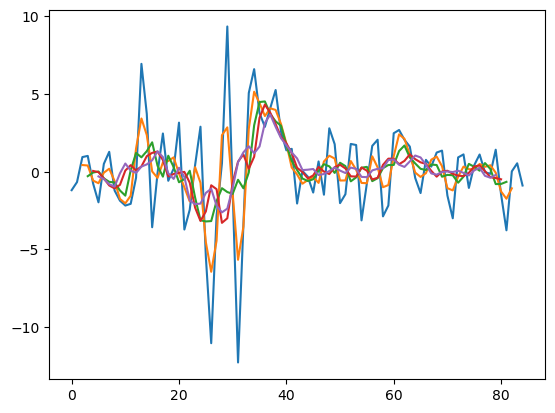

In [21]:
# Example time series of smoothed ddt(cwv)

plt.plot(ddtq_1hr[0,1,:,400,300])
plt.plot(ddtq_3hr[0,1,:,400,300])
plt.plot(ddtq_5hr[0,1,:,400,300])
plt.plot(ddtq_7hr[0,1,:,400,300])
plt.plot(ddtq_9hr[0,1,:,400,300])

In [22]:
# del cwv_1hr, cwv_3hr, cwv_5hr, cwv_7hr, cwv_9hr

In [23]:
memory_usage()

Total:      134.320787456 GB
Avail:      110.920802304 GB
Used:       20.077129728000003 GB
Free:       109.812682752 GB
Active:     21.980532736 GB
Inactive:   0.671879168 GB


### Run binning

In [24]:
def get_kstrat_cells(var_in, strat):
    var_indexed = []
    nstrat=6
    for kstrat in range(nstrat):
        indices = (strat == kstrat).nonzero()
        indexed_var = var_in[indices[0],indices[1],indices[2],indices[3]]
        var_indexed.append(indexed_var)
    return var_indexed

In [32]:
ktest=0
ddtq_indexed_1hr = get_kstrat_cells(ddtq_1hr[ktest], strat_all[ktest])
ddtq_indexed_3hr = get_kstrat_cells(ddtq_3hr[ktest], strat_all[ktest])
ddtq_indexed_5hr = get_kstrat_cells(ddtq_5hr[ktest], strat_all[ktest])
ddtq_indexed_7hr = get_kstrat_cells(ddtq_7hr[ktest], strat_all[ktest])
ddtq_indexed_9hr = get_kstrat_cells(ddtq_9hr[ktest], strat_all[ktest])

In [33]:
the_means = np.ma.zeros((5,6))
for istrat in range(6):
    the_means[0,istrat] = np.ma.mean(ddtq_indexed_1hr[istrat])
    the_means[1,istrat] = np.ma.mean(ddtq_indexed_3hr[istrat])
    the_means[2,istrat] = np.ma.mean(ddtq_indexed_5hr[istrat])
    the_means[3,istrat] = np.ma.mean(ddtq_indexed_7hr[istrat])
    the_means[4,istrat] = np.ma.mean(ddtq_indexed_9hr[istrat])

In [34]:
print(the_means)

[[ 0.05198797  0.02898941  0.36786011  0.20456513 -0.46233031 -0.10945102]
 [ 0.05000317  0.05034856  0.25593395  0.15083816 -0.36889622 -0.0866876 ]
 [ 0.04493611  0.0528668   0.16933779  0.10351682 -0.27719096 -0.06237491]
 [ 0.04230367  0.04452462  0.12886296  0.0795361  -0.21534045 -0.04570795]
 [ 0.03990192  0.03997861  0.10594726  0.06479703 -0.16777022 -0.0319958 ]]


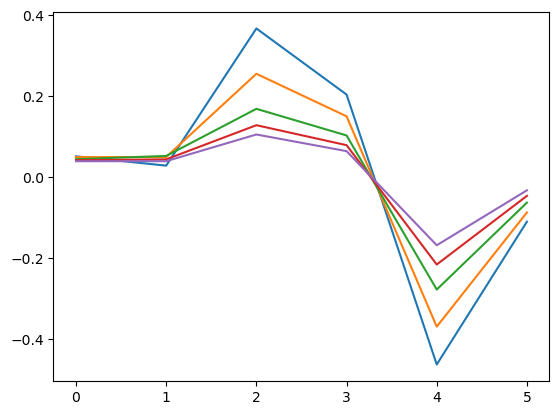

In [35]:
for inum in range(5):
    plt.plot(the_means[inum,:])

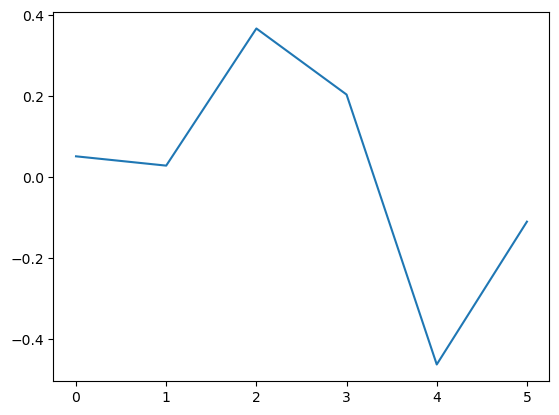

In [37]:
plt.plot(the_means[0,:])

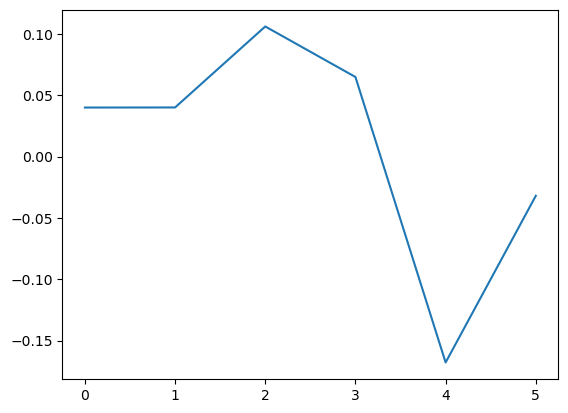

In [36]:
plt.plot(the_means[4,:])

In [25]:
memory_usage()

Total:      134.320787456 GB
Avail:      59.614314496000006 GB
Used:       72.52645888 GB
Free:       61.207879680000005 GB
Active:     70.641942528 GB
Inactive:   0.5101772800000001 GB


In [26]:
del ddtq_1hr, ddtq_3hr, ddtq_5hr, ddtq_7hr, ddtq_9hr

In [32]:
memory_usage()

Total:      134.320787456 GB
Avail:      42.290864128 GB
Used:       89.91021056000001 GB
Free:       43.945537536 GB
Active:     82.683334656 GB
Inactive:   5.7007104 GB


---
### Plotting routines

In [28]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 11}

matplotlib.rc('font', **font)

In [29]:
# Global boxplot settings

def create_boxplot(invar, title_tag, units, yscale='linear'):

    # c_name = ['Non-precip', 'Deep\nConvective', 'Congestus', 'Shallow\nConvective', 'Stratiform', 'Anvil']
    # cmap = ['white', 'teal', 'plum', 'darkorange', 'gold', 'cornflowerblue']
    c_name = ['Deep\nConvective', 'Congestus', 'Shallow\nConvective', 'Stratiform', 'Anvil']
    cmap = ['teal', 'plum', 'darkorange', 'gold', 'cornflowerblue']
    sns.set_palette(cmap)

    fig = plt.figure(figsize=(5.5,4),dpi=300)
    # fig.set_facecolor('white')
    ax = fig.subplots(nrows=1, ncols=1)
    # sns.boxplot([invar[0], invar[1], invar[2], invar[3], invar[4], invar[5]],
    sns.boxplot([invar[1], invar[2], invar[3], invar[4], invar[5]],
                width=0.7, showmeans=True, #log_scale=log_scale,
                meanprops={"marker":"o", "markerfacecolor":"white", 
                "markeredgecolor":"black", "markersize":"6"})

    ax.set_yscale(yscale)
    ax.set_xticklabels(c_name)
    plt.ylabel(units)#, weight='bold')
    plt.title("Class Averaged "+title_tag)#, weight='bold')

/tmp/ipykernel_38083/1313510787.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(c_name)
/tmp/ipykernel_38083/1313510787.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(c_name)
/tmp/ipykernel_38083/1313510787.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(c_name)


MemoryError: Unable to allocate 2.08 GiB for an array with shape (279447470,) and data type object

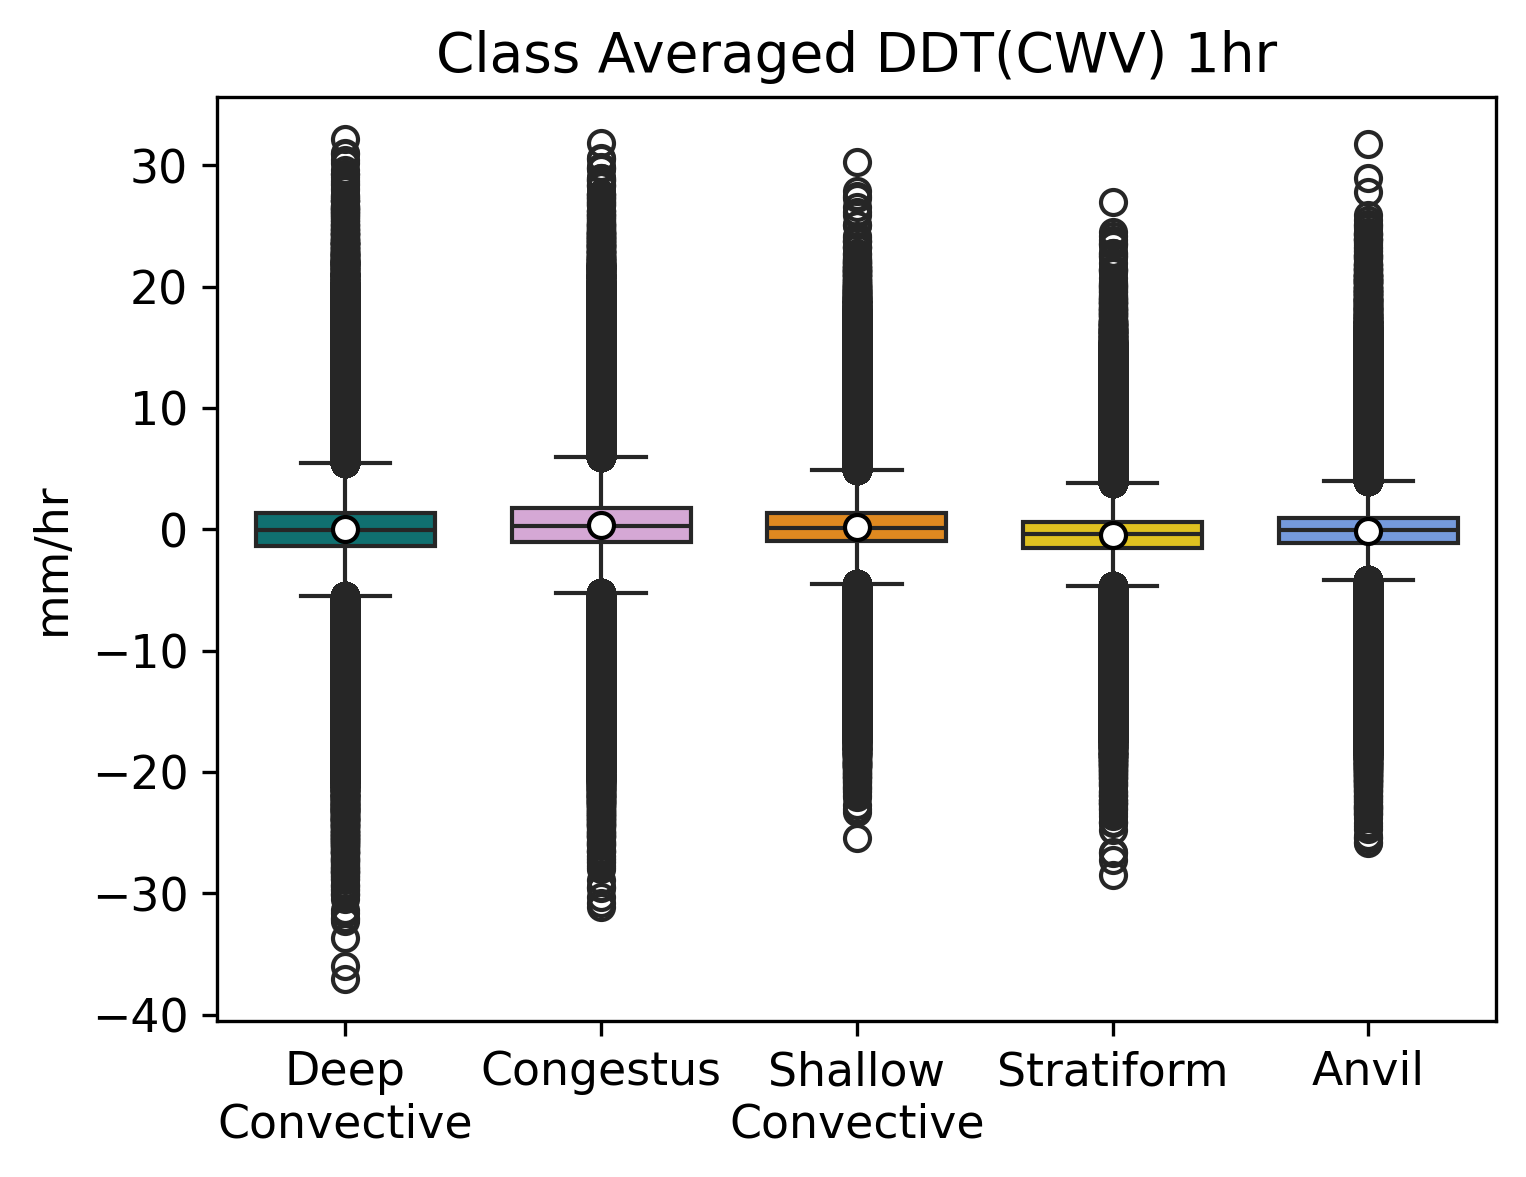

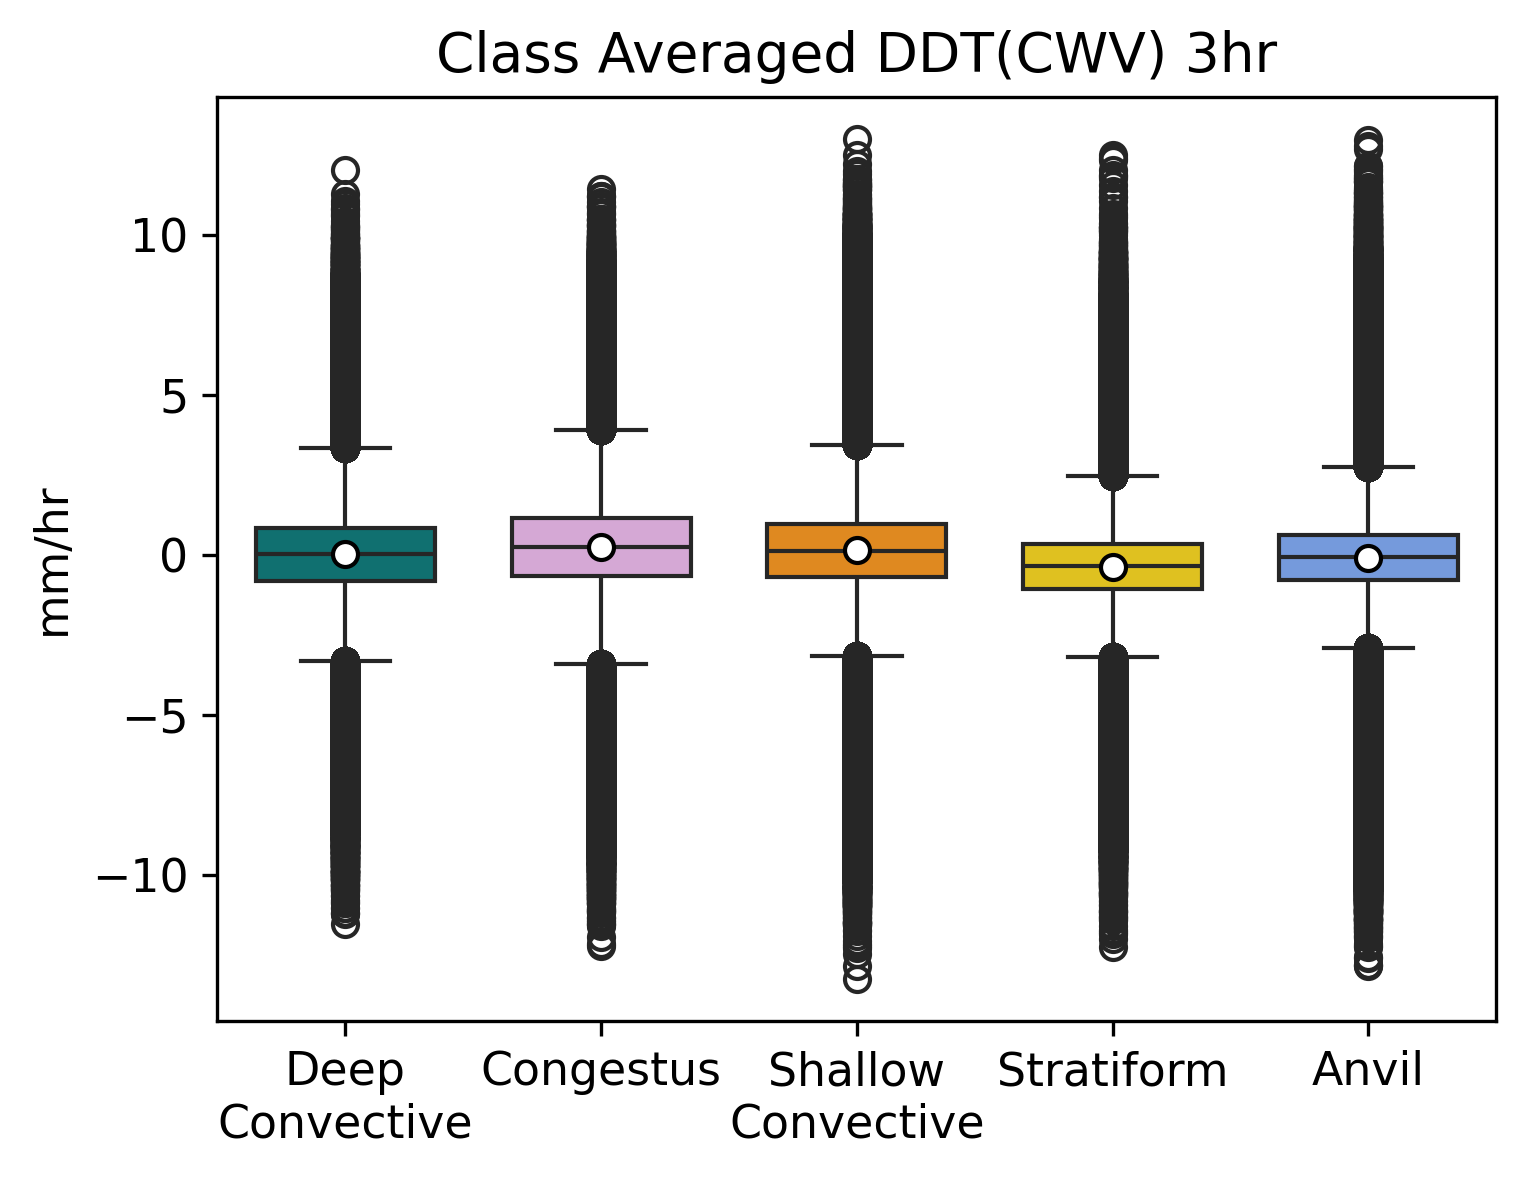

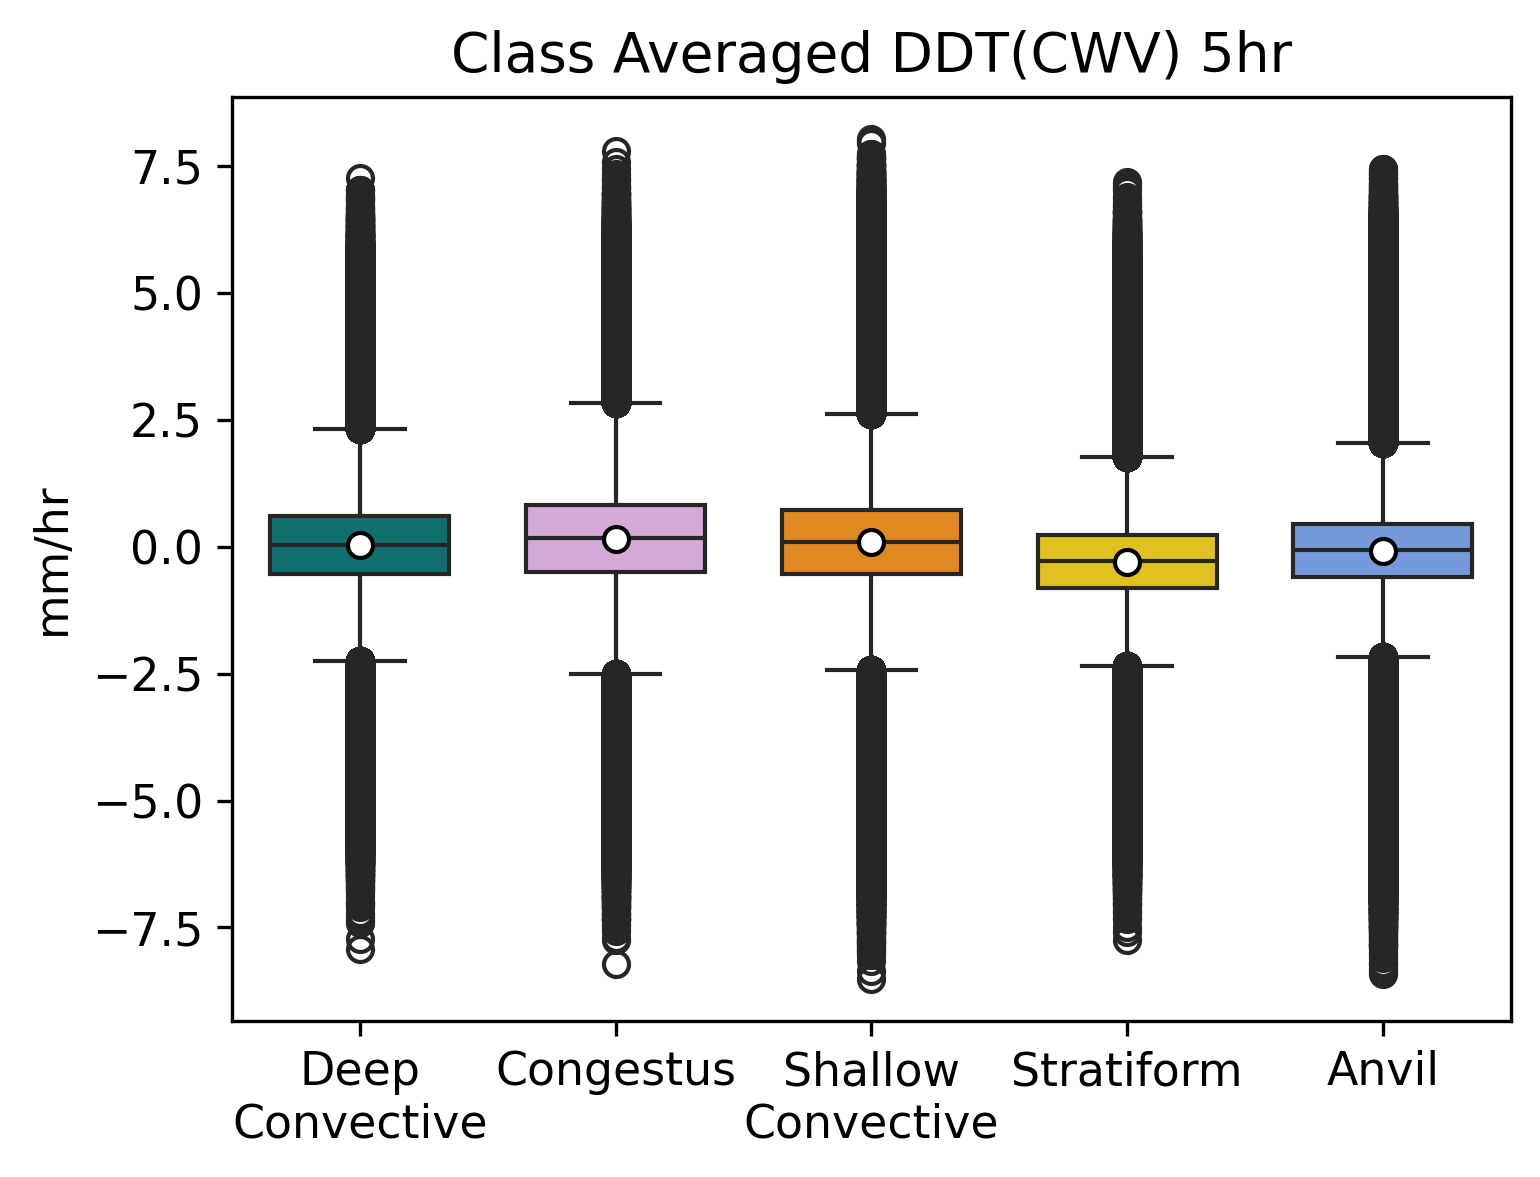

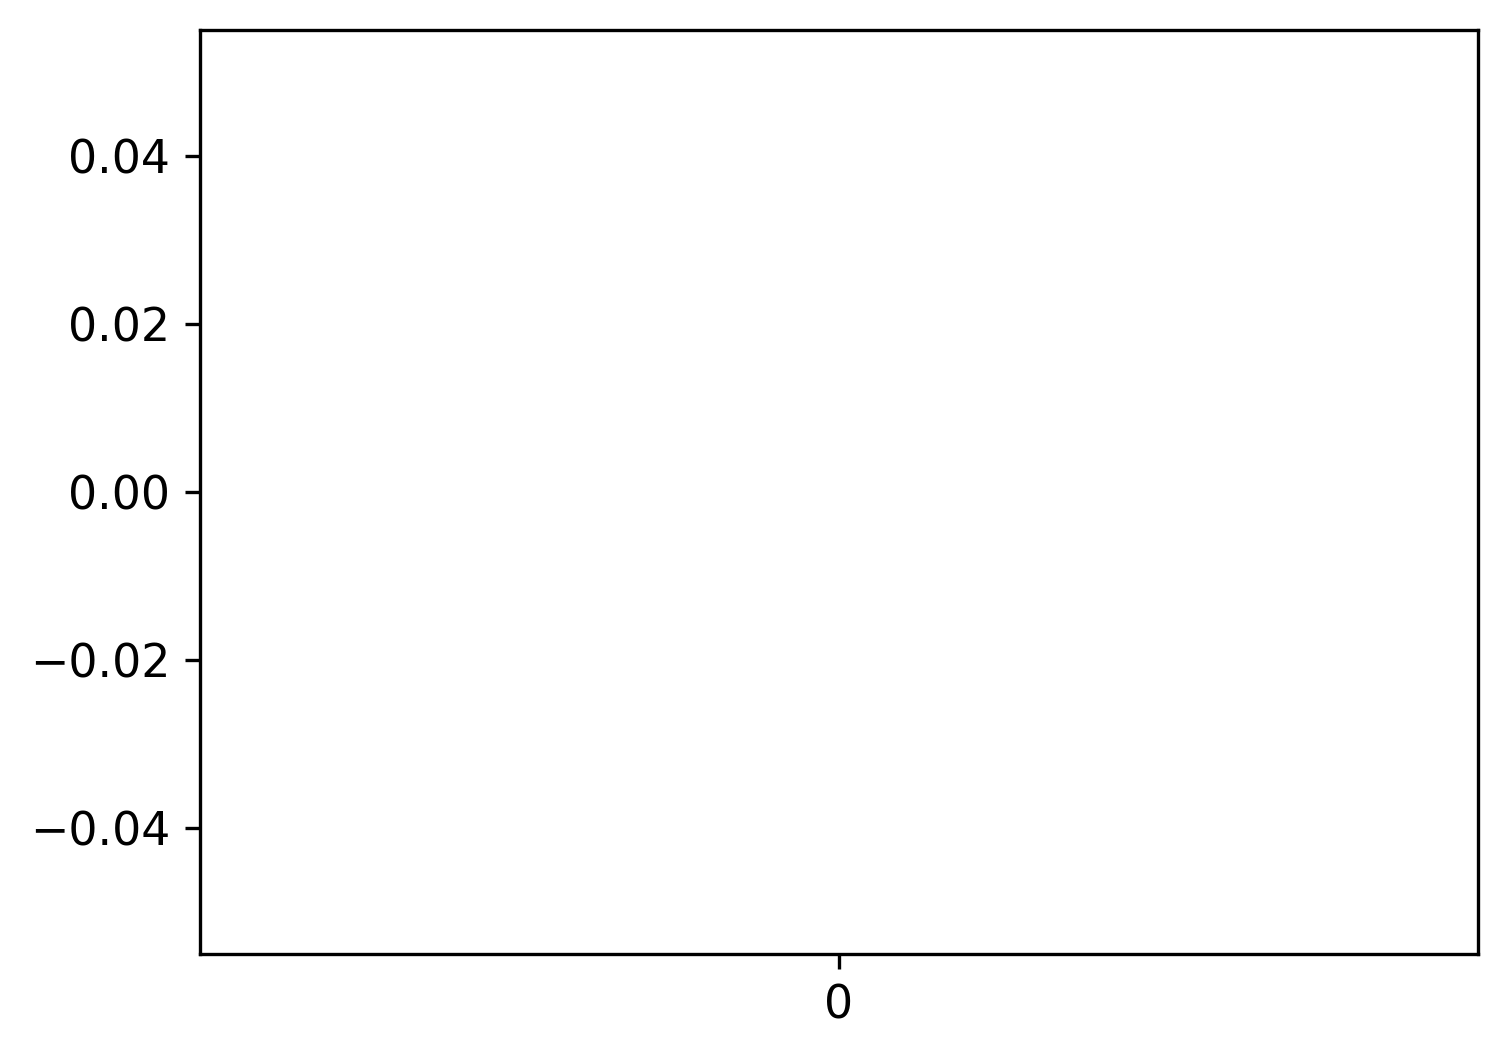

In [31]:
units = "mm/hr"
title = "DDT(CWV) "

# 1hr
title_tag = title+"1hr"
create_boxplot(ddtq_indexed_1hr, title_tag, units)

# 3hr
title_tag = title+"3hr"
create_boxplot(ddtq_indexed_3hr, title_tag, units)

# 5hr
title_tag = title+"5hr"
create_boxplot(ddtq_indexed_5hr, title_tag, units)

# 7hr
title_tag = title+"7hr"
create_boxplot(ddtq_indexed_7hr, title_tag, units)

# # 9hr
# title_tag = title+"9hr"
# create_boxplot(ddtq_indexed_9hr, title_tag, units)